In [1]:
pip install psycopg2-binary face_recognition opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
#возможно необходимо будет установить:
pip install cmake
pip install dlib
#осторожно, для второго может не хватить ОЗУ

SyntaxError: invalid syntax (<ipython-input-3-d53b71b60648>, line 2)

In [4]:
import psycopg2

In [126]:
#Указать свой Postgress
connection_db = psycopg2.connect("user='' password='' host='' dbname='postgres'")

In [127]:
db=connection_db.cursor()

#Выполнить в psql. Устанавливает расширение, которое позволяет хранить вектора задающие лица и искать ближайший к нему вектор
```
create extension if not exists cube;
drop table if exists vectors
create table vectors (id serial, file varchar, vec_low cube, vec_high cube);
create index vectors_vec_idx on vectors (vec_low, vec_high);
```

In [3]:
import sys
import dlib
import cv2
import face_recognition
import os
import postgresql

In [4]:
def save_img(file_name):
    face_detector = dlib.get_frontal_face_detector()
    image = cv2.imread(file_name)
    detected_faces = face_detector(image, 1)
    print("Found {} faces in the image file {}".format(len(detected_faces), file_name))
    for i, face_rect in enumerate(detected_faces):
        print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(),
                                                                                 face_rect.right(), face_rect.bottom()))
        crop = image[face_rect.top():face_rect.bottom(), face_rect.left():face_rect.right()]
        encodings = face_recognition.face_encodings(crop)
        if len(encodings) > 0:
            query = "INSERT INTO vectors (file, vec_low, vec_high) VALUES ('{}', CUBE(array[{}]), CUBE(array[{}]));".format(
                file_name,
                ','.join(str(s) for s in encodings[0][0:63]),
                ','.join(str(s) for s in encodings[0][64:127]),
            )
            db.execute(query)
            connection_db.commit()

In [5]:
def find_face(file_name):
    face_detector = dlib.get_frontal_face_detector()
    image = cv2.imread(file_name)
    detected_faces = face_detector(image, 1)

    print("Found {} faces in the image file {}".format(len(detected_faces), file_name))
    for i, face_rect in enumerate(detected_faces):
        print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(),
                                                                                 face_rect.right(), face_rect.bottom()))
        crop = image[face_rect.top():face_rect.bottom(), face_rect.left():face_rect.right()]

        encodings = face_recognition.face_encodings(crop)
        if len(encodings) > 0:
            query = "SELECT file FROM vectors ORDER BY " + \
                    "(CUBE(array[{}]) <-> vec_low) + (CUBE(array[{}]) <-> vec_high) ASC LIMIT 1 ;".format(
                        ','.join(str(s) for s in encodings[0][0:63]),
                        ','.join(str(s) for s in encodings[0][64:127]),
                    )
            db.execute(query)
            print("The number of parts: ", db.rowcount)
            row = db.fetchone()

            if row is not None:
                print(row)
                return row[0]
        else:
            print("No encodings")

In [6]:
import os

In [9]:
for root, dirs, files in os.walk("photos", topdown = False):
    for name in files:
        save_img(os.path.join(root, name))

KeyboardInterrupt: 

In [133]:
def dis_img(file_path):
    display(Image.open(file_path))

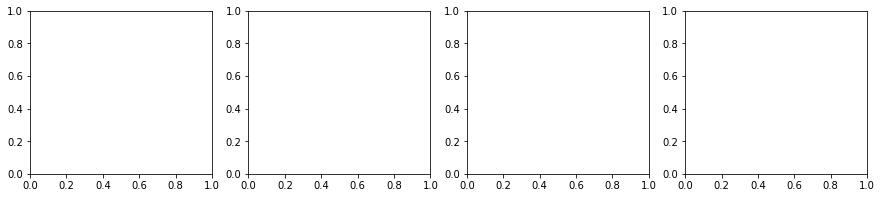

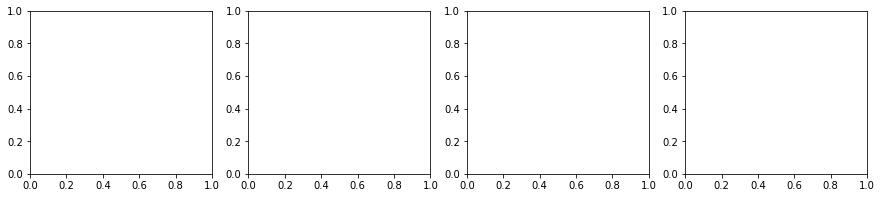

In [134]:
import matplotlib.pyplot as plt
from PIL import Image

fig,ax = plt.subplots(1,4, figsize=(15,3))
fig2,ax2 = plt.subplots(1,4, figsize=(15,3))

In [135]:
%matplotlib inline

In [136]:
i=0
for root, dirs, files in os.walk("test", topdown = False):
    for name in files:
#         print(name)
#         dis_img(os.path.join(root, name))
#         dis_img(find_face(os.path.join(root, name)))
        ax[i].imshow(Image.open(os.path.join(root, name)))
        ax2[i].imshow(Image.open(find_face(os.path.join(root, name))))
        i+=1

Found 1 faces in the image file test/solovei.jpg
- Face #0 found at Left: 245 Top: 66 Right: 335 Bottom: 156
The number of parts:  1
('photos/solovei.jpg',)
Found 1 faces in the image file test/zelen.jpg
- Face #0 found at Left: 201 Top: 116 Right: 356 Bottom: 270
The number of parts:  1
('photos/zelen.jpg',)
Found 1 faces in the image file test/navalny.jpg
- Face #0 found at Left: 253 Top: 133 Right: 408 Bottom: 288
The number of parts:  1
('photos/navalny.jpg',)
Found 1 faces in the image file test/putin.jpg
- Face #0 found at Left: 655 Top: 153 Right: 784 Bottom: 282
The number of parts:  1
('photos/putin.jpg',)


Ищу этих людей


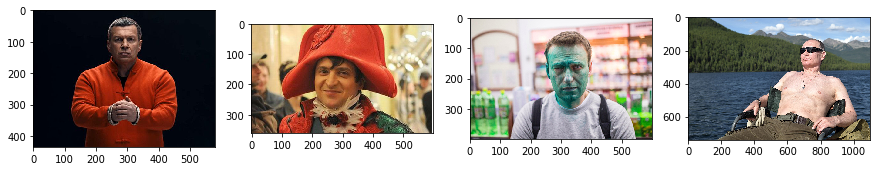

In [137]:
print("Ищу этих людей")
fig

Вот они


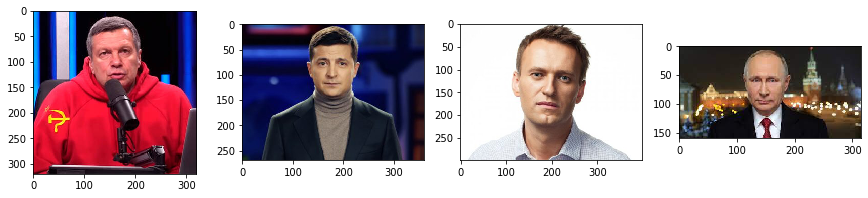

In [138]:
print("Вот они")
fig2